In [147]:
__author__ = "João Vitor Ramos Assalim"
__version__ = "1.0.0"
__maintainer__ = "João Vitor Ramos Assalim"
__email__ = "joassalim@gmail.com"
__status__ = "in development"

In [133]:
# The main idea of this project is to build an agentic AI system to solve problems

In [134]:
from langchain_core.prompts.prompt import PromptTemplate
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_groq import ChatGroq
from langchain_core.messages.base import BaseMessage
from langchain_core.output_parsers.json import JsonOutputParser

from langgraph.graph import END, StateGraph

from typing_extensions import TypedDict
from typing import List

In [135]:
web_search_tool = TavilySearchResults(max_results=3)

In [136]:
lmm = ChatGroq(model="llama3-70b-8192")

In [137]:
class GraphState(TypedDict):
    message : str
    context: str
    relevant_context: str
    response: str

In [138]:
class AgentHandler:
    def __init__(self):
        pass
    
    
    def build_summarizer_prompt(self):
        prompt = PromptTemplate(
            template="""
            You are an expert at build responses and summarize them. \n
            
            If the context is is null, you can use your knowledge base to answer it.
            If the context is not null, follow it to answer and improve it, but NEVER change the context and NEVER change meaning of the question to get a better answer.
            
            Always try to be clear and concise, and avoid adding unnecessary information.
            
            JUST ANSWER THE QUESTION, without any preamble or explaination and return the a JSON with a single key 'agent_summarization'. \n\n
            
            QUERY: {query} \n\n
            CONTEXT: {context}""",
            
            input_variables=[
                "query",
                "context",
            ],
        )
        
        return prompt


    def build_summarizer_router(self):
        summarizer_promp = self.build_summarizer_prompt()
        summarizer_router = summarizer_promp | lmm | JsonOutputParser()
        
        return summarizer_router
    
    
    def retrieve_context_info(self, state):
        query = state["message"]
        
        # implement a function to get context info from a vector database
        
        return {"context": "", "relevant_context": "not_relevant"} # return relevant if context is relevant, not_relevant if not


    def search_info_by_query(self, state):
        query = state["message"]
        search_results = web_search_tool.invoke({"query": query})
        
        return {"context": "\n".join([result["content"] for result in search_results])}
    
    
    def route_to_search(self, state):
        relevant_context = state["relevant_context"]
        
        if relevant_context == "not_relevant":
            return "research_info"
        return "draft_question"
        
        return search_results
    
    
    def summarize_response(self, state):
        summarizer_router = self.build_summarizer_router()
        
        query = state["message"]
        context = state["context"]
        
        response = summarizer_router.invoke({"query": query, "context": context})
        
        return {"response": response["agent_summarization"]}

In [139]:
agent_handler = AgentHandler()

workflow = StateGraph(GraphState)
workflow.add_node("retrieve_context", agent_handler.retrieve_context_info)
workflow.add_node("research_info_search", agent_handler.search_info_by_query)
workflow.add_node("summarize_response", agent_handler.summarize_response)

In [140]:
workflow.set_entry_point("retrieve_context")

workflow.add_conditional_edges(
    "retrieve_context",
    agent_handler.route_to_search,
    {
        "research_info": "research_info_search",
        "draft_question": "summarize_response",
    },
)
workflow.add_edge("research_info_search", "summarize_response")


workflow.add_edge("summarize_response", END)

In [141]:
app = workflow.compile()

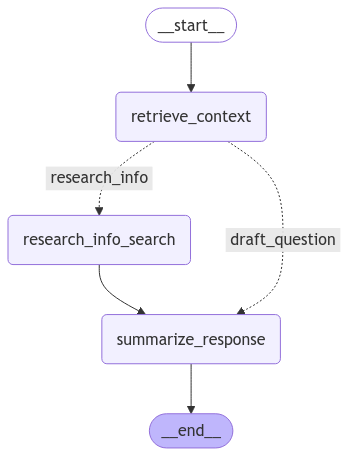

In [142]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [146]:
inputs = {"message": "Where Messi is playing?"}
output = app.invoke(inputs)
output["response"]

'Lionel Messi is playing for Inter Miami.'